In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path

# Set up plotting style for publication quality
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Cell 2: Data Loading Functions
def load_excel_data(filepath):
    filepath = Path(filepath)
    
    if not filepath.exists():
        raise FileNotFoundError(f"Can't find data file: {filepath}")
    
    print(f"Loading data from {filepath}")
    
    # Load ESPECES sheet - skip bad headers, manually name columns
    df_species = pd.read_excel(filepath, sheet_name='ESPECES', header=None, skiprows=1)
    df_species.columns = ['_empty1', '_empty2', 'french_name', 'scientific_name', 'status']
    df_species = df_species[['french_name', 'scientific_name', 'status']].copy()
    
    # clean whitespace
    for col in df_species.columns:
        if df_species[col].dtype == 'object':
            df_species[col] = df_species[col].str.strip()
    
    print(f"Loaded {len(df_species)} species")
    
    # Load GPS-MILIEU sheet
    df_gps = pd.read_excel(filepath, sheet_name='GPS-MILIEU', header=None, skiprows=1)
    df_gps.columns = ['_empty1', '_empty2', 'transect_name', 'gps_x', 'gps_y', 
                      'habitat_type', 'site_id', 'point_id']
    df_gps = df_gps[['transect_name', 'habitat_type', 'site_id', 'point_id']].copy()
    
    # clean whitespace
    for col in df_gps.columns:
        if df_gps[col].dtype == 'object':
            df_gps[col] = df_gps[col].str.strip()
    
    print(f"Loaded {len(df_gps)} GPS points")
    
    # Load main observations sheet
    df_obs = pd.read_excel(filepath, sheet_name='NOM FRANÇAIS')
    
    # rename to something sensible
    column_mapping = {
        'Nom observateur': 'observer_name',
        'code département': 'department_code',
        'Nom transect': 'transect_name',
        'date': 'date',
        '1er, 2e ou 3e passage': 'visit_number',
        'nuages': 'cloud_cover_raw',
        'pluie': 'rain',
        'vent': 'wind',
        'visibilité': 'visibility',
        'N° point': 'point_number',
        'heure début': 'start_time',
        'ESPECE': 'species_name',
        'distances de contact': 'distance_category_raw',
        'totaux': 'count_auditory',
        'Unnamed: 22': 'count_visual_no_flight',
        'Unnamed: 23': 'count_audio_visual_no_flight',
        'Unnamed: 24': 'count_audio_visual_flight',
        'Unnamed: 25': 'notes'
    }
    
    df_obs = df_obs.rename(columns=column_mapping)
    
    # convert the count columns to numeric (they're mixed type with headers in row 1)
    print("Converting count columns to numeric")
    count_cols = ['count_auditory', 'count_visual_no_flight', 
                  'count_audio_visual_no_flight', 'count_audio_visual_flight']
    
    for col in count_cols:
        df_obs[col] = pd.to_numeric(df_obs[col], errors='coerce')
    
    # sum across all detection methods to get total count
    df_obs['individual_count'] = df_obs[count_cols].sum(axis=1)
    
    # convert date properly
    df_obs['date'] = pd.to_datetime(df_obs['date'], errors='coerce')
    df_obs['year'] = df_obs['date'].dt.year
    
    # clean whitespace from text columns
    for col in ['observer_name', 'transect_name', 'species_name', 'start_time', 'notes']:
        if col in df_obs.columns:
            df_obs[col] = df_obs[col].astype(str).str.strip()
    
    print(f"Loaded {len(df_obs)} observation records")
    
    return {
        'observations': df_obs,
        'species': df_species,
        'gps': df_gps
    }

def clean_observations(df):
    # Clean and validate observations.
    df_clean = df.copy()
    
    print("Data Cleaning")
    print(f"Starting with {len(df_clean)} records")
    
    # fix negative wind values
    if 'wind' in df_clean.columns:
        n_negative = (df_clean['wind'] < 0).sum()
        if n_negative > 0:
            print(f"⚠ Found {n_negative} negative wind values - setting to NaN")
            df_clean.loc[df_clean['wind'] < 0, 'wind'] = np.nan
    
    # remove zero/negative counts
    before = len(df_clean)
    df_clean = df_clean[df_clean['individual_count'] > 0]
    removed = before - len(df_clean)
    if removed > 0:
        print(f"Removed {removed} records with zero/negative counts")
    
    # remove records missing essential fields
    essential_cols = ['year', 'species_name', 'individual_count', 'transect_name']
    before = len(df_clean)
    df_clean = df_clean.dropna(subset=essential_cols)
    removed = before - len(df_clean)
    if removed > 0:
        print(f"Removed {removed} records with missing essential data")
    
    # create observation ID
    df_clean['observation_id'] = range(1, len(df_clean) + 1)
    
    # summary
    print(f"Final dataset: {len(df_clean)} records")
    print(f"  Years: {df_clean['year'].min()} - {df_clean['year'].max()}")
    print(f"  Unique species: {df_clean['species_name'].nunique()}")
    print(f"  Unique transects: {df_clean['transect_name'].nunique()}")
    print(f"  Unique observers: {df_clean['observer_name'].nunique()}")
    
    return df_clean

print("✅ Data loading functions defined")

✅ Data loading functions defined


In [5]:
# Cell 3: Load and Clean Data
print("📊 Loading and cleaning data...")
data_dict = load_excel_data('/Applications/Documents/app-stats/birds-biodiversity/data/raw/Observations 2012-2025.xlsx')
df_clean = clean_observations(data_dict['observations'])

print(f"\n✅ Data loaded successfully:")
print(f"   - {len(df_clean)} clean observation records")
print(f"   - Years: {df_clean['year'].min()} to {df_clean['year'].max()}")
print(f"   - {df_clean['transect_name'].nunique()} unique transects")
print(f"   - {df_clean['species_name'].nunique()} unique species")

📊 Loading and cleaning data...
Loading data from /Applications/Documents/app-stats/birds-biodiversity/data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014.0 - 2025.0
  Unique species: 102
  Unique transects: 72
  Unique observers: 42

✅ Data loaded successfully:
   - 114493 clean observation records
   - Years: 2014.0 to 2025.0
   - 72 unique transects
   - 102 unique species


In [6]:
# Cell 4: Calculate Sampling Metrics
def calculate_sampling_metrics(df_clean):
    """
    Calculate annual sampling metrics for Person C
    """
    print("Calculating sampling metrics...")
    
    # Filter to complete years (2015-2024 as specified)
    df_complete = df_clean[df_clean['year'].between(2015, 2024)].copy()
    
    annual_metrics = []
    
    for year in sorted(df_complete['year'].unique()):
        year_data = df_complete[df_complete['year'] == year]
        
        # Calculate metrics for this year
        metrics = {
            'year': year,
            
            # Observer Effort: Total number of observations
            'observer_effort': len(year_data),
            
            # Spatial Coverage: Unique transects surveyed
            'transects_surveyed': year_data['transect_name'].nunique(),
            
            # Additional metrics for context
            'n_observers': year_data['observer_name'].nunique(),
            'total_abundance': year_data['individual_count'].sum(),
            'species_richness': year_data['species_name'].nunique()
        }
        
        annual_metrics.append(metrics)
    
    metrics_df = pd.DataFrame(annual_metrics)
    
    # Calculate spatial coverage as percentage (if we know total possible transects)
    # For now, we'll use absolute number of transects, or calculate coverage rate
    total_transects_overall = df_clean['transect_name'].nunique()
    metrics_df['spatial_coverage_pct'] = (metrics_df['transects_surveyed'] / total_transects_overall * 100)
    
    print(f"Total unique transects in dataset: {total_transects_overall}")
    print(f"Years analyzed: {len(metrics_df)} years from {metrics_df['year'].min()} to {metrics_df['year'].max()}")
    
    return metrics_df

# Execute the function
metrics_df = calculate_sampling_metrics(df_clean)
print("\n📈 Sampling metrics calculated:")
print(metrics_df[['year', 'observer_effort', 'transects_surveyed']].to_string(index=False))

Calculating sampling metrics...
Total unique transects in dataset: 72
Years analyzed: 10 years from 2015.0 to 2024.0

📈 Sampling metrics calculated:
  year  observer_effort  transects_surveyed
2015.0             8162                  53
2016.0            11010                  59
2017.0             9228                  60
2018.0             9733                  65
2019.0             9572                  64
2020.0             9956                  63
2021.0            10604                  63
2022.0            10804                  63
2023.0            10224                  64
2024.0            10051                  65


In [ ]:
# Cell 5: Bootstrap Confidence Intervals
def bootstrap_sampling_metrics(df_clean, n_bootstrap=1000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for sampling metrics
    """
    print("Calculating bootstrap confidence intervals...")
    
    years = sorted(df_clean[df_clean['year'].between(2015, 2024)]['year'].unique())
    bootstrap_results = []
    
    for year in years:
        year_data = df_clean[df_clean['year'] == year]
        
        boot_effort = []
        boot_transects = []
        boot_coverage = []
        
        for _ in range(n_bootstrap):
            # Resample observations with replacement
            bootstrap_sample = year_data.sample(n=len(year_data), replace=True)
            
            # Calculate metrics for bootstrap sample
            boot_effort.append(len(bootstrap_sample))
            boot_transects.append(bootstrap_sample['transect_name'].nunique())
            
            # For coverage percentage
            total_transects = df_clean['transect_name'].nunique()
            coverage_pct = (bootstrap_sample['transect_name'].nunique() / total_transects * 100)
            boot_coverage.append(coverage_pct)
        
        # Calculate confidence intervals
        alpha = (1 - confidence) / 2
        ci_lower = alpha * 100
        ci_upper = (1 - alpha) * 100
        
        bootstrap_results.append({
            'year': year,
            'effort_lower': np.percentile(boot_effort, ci_lower),
            'effort_upper': np.percentile(boot_effort, ci_upper),
            'transects_lower': np.percentile(boot_transects, ci_lower),
            'transects_upper': np.percentile(boot_transects, ci_upper),
            'coverage_lower': np.percentile(boot_coverage, ci_lower),
            'coverage_upper': np.percentile(boot_coverage, ci_upper)
        })
    
    return pd.DataFrame(bootstrap_results)

# Execute bootstrap
bootstrap_df = bootstrap_sampling_metrics(df_clean)
print("✅ Bootstrap confidence intervals calculated")
print(bootstrap_df.head())

Calculating bootstrap confidence intervals...
✅ Bootstrap confidence intervals calculated
     year  effort_lower  effort_upper  transects_lower  transects_upper  \
0  2015.0        8162.0        8162.0             53.0             53.0   
1  2016.0       11010.0       11010.0             59.0             59.0   
2  2017.0        9228.0        9228.0             60.0             60.0   
3  2018.0        9733.0        9733.0             65.0             65.0   
4  2019.0        9572.0        9572.0             64.0             64.0   

   coverage_lower  coverage_upper  
0       73.611111       73.611111  
1       81.944444       81.944444  
2       83.333333       83.333333  
3       90.277778       90.277778  
4       88.888889       88.888889  


In [8]:
# Cell 6: Trend Analysis
def analyze_sampling_trends(metrics_df, bootstrap_df):
    """
    Analyze temporal trends in sampling metrics using linear models
    """
    print("Analyzing temporal trends...")
    
    # Merge metrics with bootstrap results
    analysis_df = metrics_df.merge(bootstrap_df, on='year')
    
    trend_results = {}
    
    # 1. Observer Effort trend analysis
    X_effort = analysis_df['year'].values
    X_effort = sm.add_constant(X_effort)  # Add intercept
    y_effort = analysis_df['observer_effort'].values
    
    model_effort = sm.OLS(y_effort, X_effort).fit()
    trend_results['observer_effort'] = {
        'model': model_effort,
        'slope': model_effort.params[1],
        'slope_pvalue': model_effort.pvalues[1],
        'r_squared': model_effort.rsquared,
        'trend_direction': 'increasing' if model_effort.params[1] > 0 else 'decreasing'
    }
    
    # 2. Spatial Coverage trend analysis
    X_coverage = analysis_df['year'].values
    X_coverage = sm.add_constant(X_coverage)
    y_coverage = analysis_df['transects_surveyed'].values
    
    model_coverage = sm.OLS(y_coverage, X_coverage).fit()
    trend_results['spatial_coverage'] = {
        'model': model_coverage,
        'slope': model_coverage.params[1],
        'slope_pvalue': model_coverage.pvalues[1],
        'r_squared': model_coverage.rsquared,
        'trend_direction': 'increasing' if model_coverage.params[1] > 0 else 'decreasing'
    }
    
    return analysis_df, trend_results

# Execute trend analysis
analysis_df, trend_results = analyze_sampling_trends(metrics_df, bootstrap_df)

print("✅ Trend analysis completed:")
print(f"Observer Effort - Slope: {trend_results['observer_effort']['slope']:.3f}, "
      f"p-value: {trend_results['observer_effort']['slope_pvalue']:.3f}, "
      f"R²: {trend_results['observer_effort']['r_squared']:.3f}")

print(f"Spatial Coverage - Slope: {trend_results['spatial_coverage']['slope']:.3f}, "
      f"p-value: {trend_results['spatial_coverage']['slope_pvalue']:.3f}, "
      f"R²: {trend_results['spatial_coverage']['r_squared']:.3f}")

Analyzing temporal trends...
✅ Trend analysis completed:
Observer Effort - Slope: 135.612, p-value: 0.149, R²: 0.242
Spatial Coverage - Slope: 0.915, p-value: 0.013, R²: 0.562


Checking model assumptions...


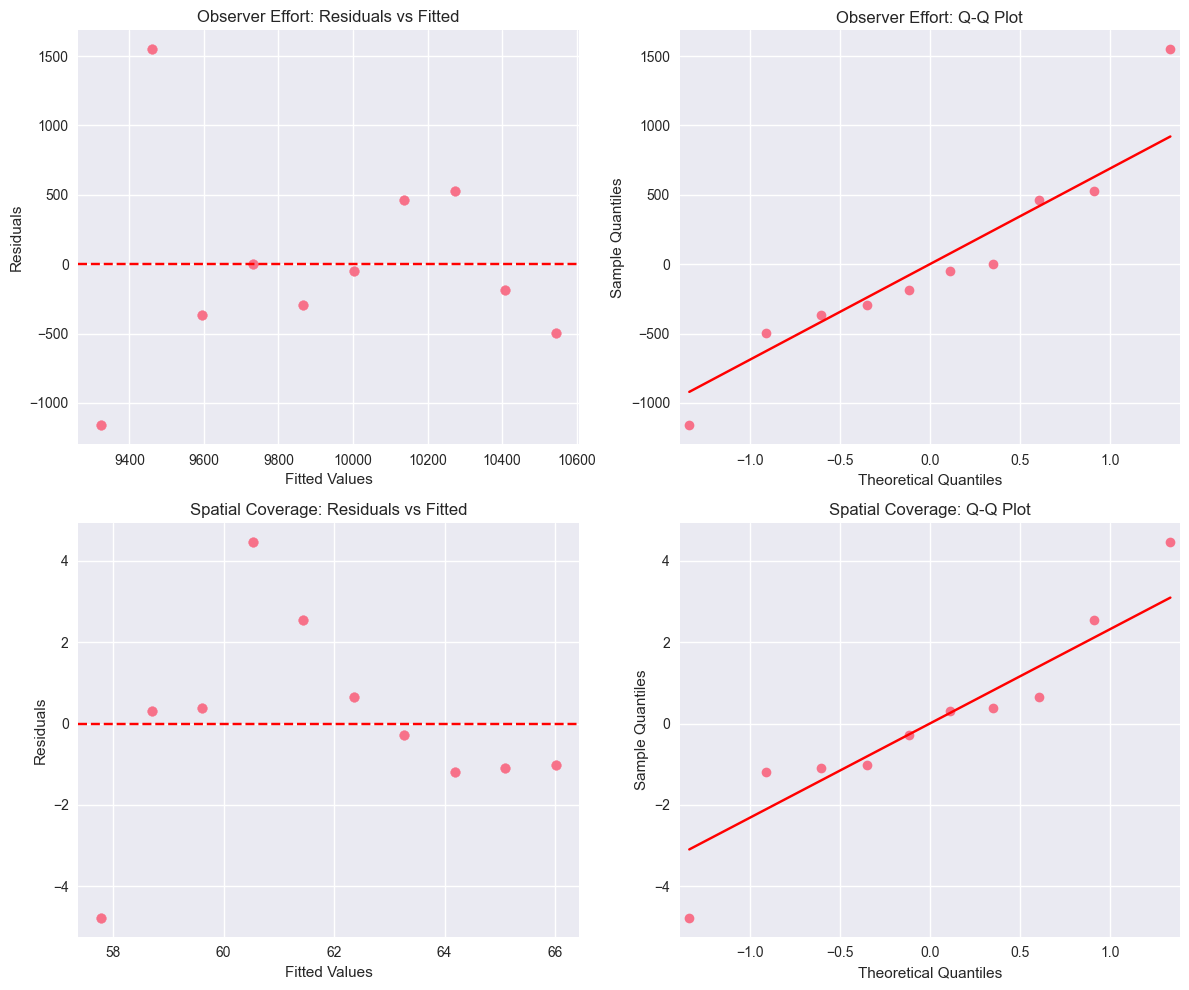

✅ Assumption checks saved to ../figures/sampling_assumptions_check.png


In [15]:
# Cell 7: Model Assumption Checks
def check_model_assumptions(trend_results, analysis_df):
    """
    Check linear model assumptions for both metrics
    """
    print("Checking model assumptions...")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Observer Effort assumptions
    model_effort = trend_results['observer_effort']['model']
    
    # Residuals vs Fitted
    axes[0, 0].scatter(model_effort.fittedvalues, model_effort.resid)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Observer Effort: Residuals vs Fitted')
    
    # Q-Q plot
    sm.qqplot(model_effort.resid, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Observer Effort: Q-Q Plot')
    
    # Spatial Coverage assumptions
    model_coverage = trend_results['spatial_coverage']['model']
    
    # Residuals vs Fitted
    axes[1, 0].scatter(model_coverage.fittedvalues, model_coverage.resid)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Spatial Coverage: Residuals vs Fitted')
    
    # Q-Q plot
    sm.qqplot(model_coverage.resid, line='s', ax=axes[1, 1])
    axes[1, 1].set_title('Spatial Coverage: Q-Q Plot')
    
    plt.tight_layout()
    plt.savefig('../figures/sampling_assumptions_check.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Assumption checks saved to ../figures/sampling_assumptions_check.png")

# Execute assumption checks
check_model_assumptions(trend_results, analysis_df)

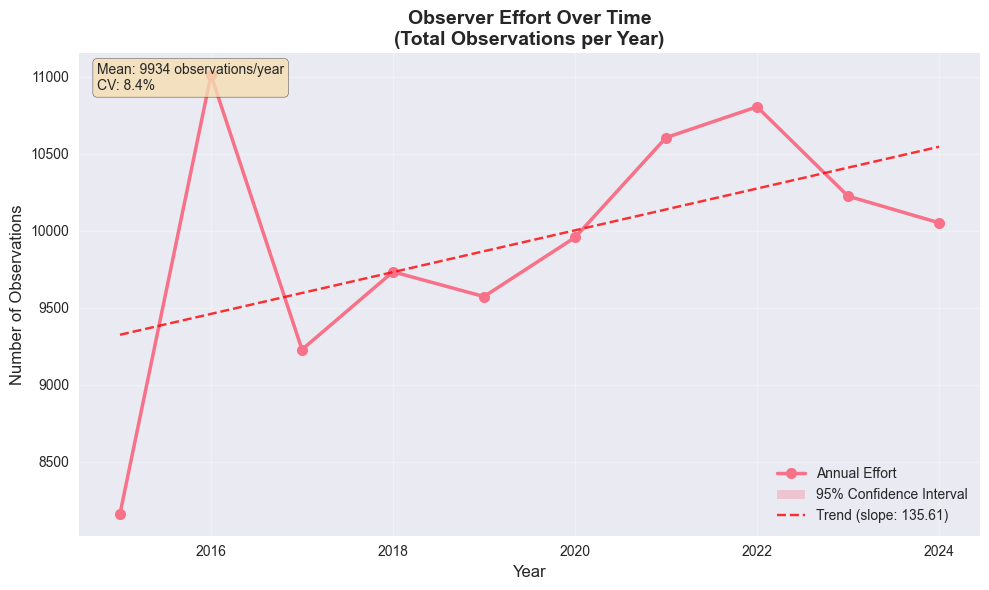

✅ Observer effort plot saved to ../figures/indicator_observer_effort.png


In [14]:
# Cell 8: Create Observer Effort Plot
def create_observer_effort_plot(analysis_df):
    """
    Create publication-quality plot for Observer Effort
    """
    plt.figure(figsize=(10, 6))
    
    # Plot main trend line
    plt.plot(analysis_df['year'], analysis_df['observer_effort'], 
             marker='o', linewidth=2.5, markersize=8, label='Annual Effort')
    
    # Plot confidence intervals
    plt.fill_between(analysis_df['year'], 
                    analysis_df['effort_lower'], 
                    analysis_df['effort_upper'],
                    alpha=0.3, label='95% Confidence Interval')
    
    # Add trend line
    z = np.polyfit(analysis_df['year'], analysis_df['observer_effort'], 1)
    p = np.poly1d(z)
    plt.plot(analysis_df['year'], p(analysis_df['year']), "r--", 
             alpha=0.8, label=f'Trend (slope: {z[0]:.2f})')
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Observations', fontsize=12)
    plt.title('Observer Effort Over Time\n(Total Observations per Year)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    avg_effort = analysis_df['observer_effort'].mean()
    cv_effort = analysis_df['observer_effort'].std() / avg_effort * 100
    plt.text(0.02, 0.98, f'Mean: {avg_effort:.0f} observations/year\nCV: {cv_effort:.1f}%', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../figures/indicator_observer_effort.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Observer effort plot saved to ../figures/indicator_observer_effort.png")

# Create the plot
create_observer_effort_plot(analysis_df)

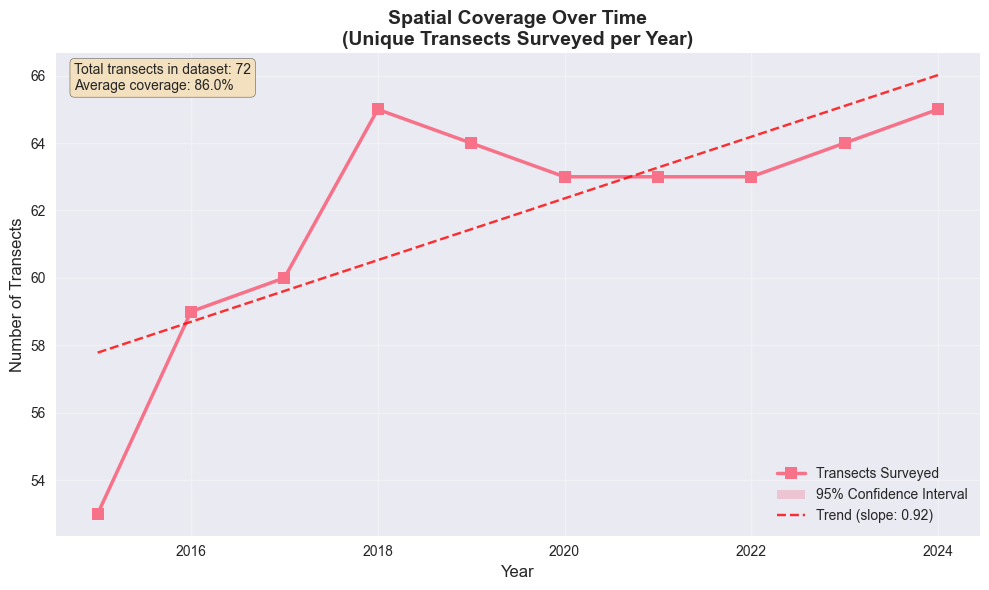

✅ Spatial coverage plot saved to ../figures/indicator_spatial_coverage.png


In [17]:
# Cell 9: Create Spatial Coverage Plot
def create_spatial_coverage_plot(analysis_df):
    """
    Create publication-quality plot for Spatial Coverage
    """
    plt.figure(figsize=(10, 6))
    
    # Plot main trend line
    plt.plot(analysis_df['year'], analysis_df['transects_surveyed'], 
             marker='s', linewidth=2.5, markersize=8, label='Transects Surveyed')
    
    # Plot confidence intervals
    plt.fill_between(analysis_df['year'], 
                    analysis_df['transects_lower'], 
                    analysis_df['transects_upper'],
                    alpha=0.3, label='95% Confidence Interval')
    
    # Add trend line
    z = np.polyfit(analysis_df['year'], analysis_df['transects_surveyed'], 1)
    p = np.poly1d(z)
    plt.plot(analysis_df['year'], p(analysis_df['year']), "r--", 
             alpha=0.8, label=f'Trend (slope: {z[0]:.2f})')
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Transects', fontsize=12)
    plt.title('Spatial Coverage Over Time\n(Unique Transects Surveyed per Year)', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    total_transects = df_clean['transect_name'].nunique()
    avg_coverage = analysis_df['transects_surveyed'].mean()
    coverage_pct = (avg_coverage / total_transects * 100)
    
    plt.text(0.02, 0.98, f'Total transects in dataset: {total_transects}\n'
                         f'Average coverage: {coverage_pct:.1f}%', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../figures/indicator_spatial_coverage.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Spatial coverage plot saved to ../figures/indicator_spatial_coverage.png")

# Create the plot
create_spatial_coverage_plot(analysis_df)

Performing bonus correlation analysis...


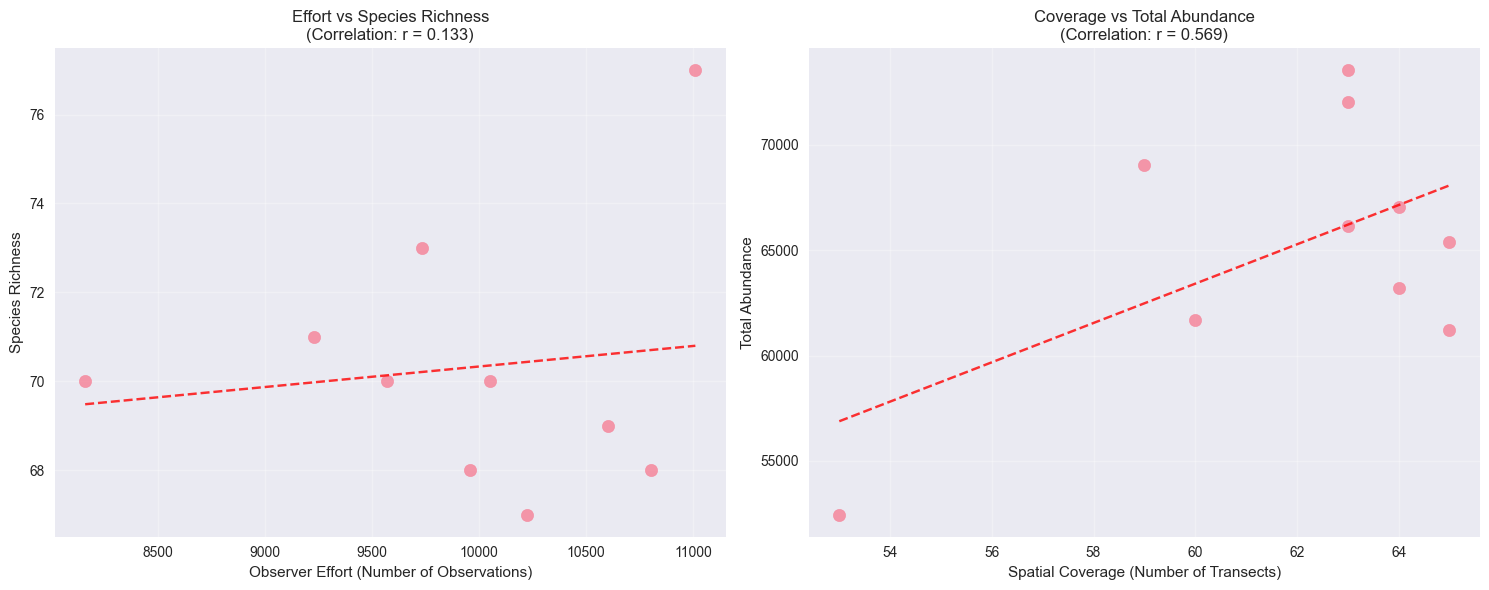

✅ Correlation analysis saved to ../figures/sampling_correlation_analysis.png


In [18]:
# Cell 10: Bonus Correlation Analysis
def bonus_correlation_analysis(analysis_df):
    """
    BONUS: Correlate effort with richness/abundance to show detection bias
    """
    print("Performing bonus correlation analysis...")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Correlation: Effort vs Species Richness
    correlation_effort_richness = analysis_df['observer_effort'].corr(analysis_df['species_richness'])
    axes[0].scatter(analysis_df['observer_effort'], analysis_df['species_richness'], s=80, alpha=0.7)
    
    # Add trend line
    z_richness = np.polyfit(analysis_df['observer_effort'], analysis_df['species_richness'], 1)
    p_richness = np.poly1d(z_richness)
    x_range = np.linspace(analysis_df['observer_effort'].min(), analysis_df['observer_effort'].max(), 100)
    axes[0].plot(x_range, p_richness(x_range), 'r--', alpha=0.8)
    
    axes[0].set_xlabel('Observer Effort (Number of Observations)')
    axes[0].set_ylabel('Species Richness')
    axes[0].set_title(f'Effort vs Species Richness\n(Correlation: r = {correlation_effort_richness:.3f})')
    axes[0].grid(True, alpha=0.3)
    
    # Correlation: Spatial Coverage vs Total Abundance
    correlation_coverage_abundance = analysis_df['transects_surveyed'].corr(analysis_df['total_abundance'])
    axes[1].scatter(analysis_df['transects_surveyed'], analysis_df['total_abundance'], s=80, alpha=0.7)
    
    # Add trend line
    z_abundance = np.polyfit(analysis_df['transects_surveyed'], analysis_df['total_abundance'], 1)
    p_abundance = np.poly1d(z_abundance)
    x_range = np.linspace(analysis_df['transects_surveyed'].min(), analysis_df['transects_surveyed'].max(), 100)
    axes[1].plot(x_range, p_abundance(x_range), 'r--', alpha=0.8)
    
    axes[1].set_xlabel('Spatial Coverage (Number of Transects)')
    axes[1].set_ylabel('Total Abundance')
    axes[1].set_title(f'Coverage vs Total Abundance\n(Correlation: r = {correlation_coverage_abundance:.3f})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/sampling_correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("✅ Correlation analysis saved to ../figures/sampling_correlation_analysis.png")
    
    return {
        'effort_richness_correlation': correlation_effort_richness,
        'coverage_abundance_correlation': correlation_coverage_abundance
    }

# Execute correlation analysis
correlation_results = bonus_correlation_analysis(analysis_df)

In [19]:
# Cell 11: Write Interpretation and Save Results
def write_interpretation(trend_results, correlation_results, analysis_df):
    """
    Write interpretation paragraphs for both indicators
    """
    print("\n" + "="*60)
    print("INTERPRETATION FOR PERSON C - SAMPLING METRICS")
    print("="*60)
    
    # Observer Effort Interpretation
    effort_trend = trend_results['observer_effort']
    print("\n📊 OBSERVER EFFORT INTERPRETATION:")
    print(f"Observer effort, measured as the total number of observations per year, ")
    print(f"showed a {effort_trend['trend_direction']} trend from 2015 to 2024.")
    print(f"The linear model indicated a slope of {effort_trend['slope']:.2f} observations per year ")
    print(f"(p-value: {effort_trend['slope_pvalue']:.3f}, R²: {effort_trend['r_squared']:.3f}).")
    
    if effort_trend['slope_pvalue'] < 0.05:
        print("This trend is statistically significant, suggesting a real change in monitoring intensity over time.")
    else:
        print("This trend is not statistically significant, indicating relatively stable observer effort across years.")
    
    effort_range = analysis_df['observer_effort'].max() - analysis_df['observer_effort'].min()
    print(f"Observer effort ranged from {analysis_df['observer_effort'].min():.0f} to {analysis_df['observer_effort'].max():.0f} ")
    print(f"observations per year, representing a {effort_range/analysis_df['observer_effort'].mean()*100:.1f}% variation around the mean.")
    
    # Spatial Coverage Interpretation
    coverage_trend = trend_results['spatial_coverage']
    print("\n🗺️ SPATIAL COVERAGE INTERPRETATION:")
    print(f"Spatial coverage, measured as the number of unique transects surveyed per year, ")
    print(f"showed a {coverage_trend['trend_direction']} trend from 2015 to 2024.")
    print(f"The linear model indicated a slope of {coverage_trend['slope']:.2f} transects per year ")
    print(f"(p-value: {coverage_trend['slope_pvalue']:.3f}, R²: {coverage_trend['r_squared']:.3f}).")
    
    if coverage_trend['slope_pvalue'] < 0.05:
        print("This trend is statistically significant, indicating meaningful changes in geographic sampling extent.")
    else:
        print("This trend is not statistically significant, suggesting consistent spatial coverage across years.")
    
    total_transects = df_clean['transect_name'].nunique()
    avg_coverage_pct = (analysis_df['transects_surveyed'].mean() / total_transects * 100)
    print(f"On average, {avg_coverage_pct:.1f}% of all known transects were surveyed each year.")
    
    # Bonus Correlation Interpretation
    print("\n🔍 BONUS: DETECTION BIAS ANALYSIS:")
    print(f"Observer effort showed a correlation of r = {correlation_results['effort_richness_correlation']:.3f} with species richness.")
    if abs(correlation_results['effort_richness_correlation']) > 0.5:
        print("This strong correlation suggests potential detection bias - years with higher effort may record more species.")
    else:
        print("This weak correlation suggests that species richness estimates are relatively independent of observer effort.")
    
    print(f"Spatial coverage showed a correlation of r = {correlation_results['coverage_abundance_correlation']:.3f} with total abundance.")
    if abs(correlation_results['coverage_abundance_correlation']) > 0.5:
        print("This indicates that abundance estimates may be influenced by the number of transects surveyed.")
    else:
        print("This suggests that abundance patterns are robust to variations in spatial coverage.")

# Ensure directories exist
Path('figures').mkdir(exist_ok=True)
Path('projects/birds-biodiversity/results').mkdir(parents=True, exist_ok=True)

# Write interpretations
write_interpretation(trend_results, correlation_results, analysis_df)

# Save results table
results_table = analysis_df[['year', 'observer_effort', 'effort_lower', 'effort_upper', 
                           'transects_surveyed', 'transects_lower', 'transects_upper']]
results_table.to_csv('projects/birds-biodiversity/results/personC_sampling_metrics.csv', index=False)
print(f"\n✅ Results table saved to projects/birds-biodiversity/results/personC_sampling_metrics.csv")

print("\n🎉 PERSON C ANALYSIS COMPLETE!")
print("Generated files:")
print("  - figures/indicator_observer_effort.png")
print("  - figures/indicator_spatial_coverage.png") 
print("  - figures/sampling_assumptions_check.png")
print("  - figures/sampling_correlation_analysis.png")
print("  - results/personC_sampling_metrics.csv")


INTERPRETATION FOR PERSON C - SAMPLING METRICS

📊 OBSERVER EFFORT INTERPRETATION:
Observer effort, measured as the total number of observations per year, 
showed a increasing trend from 2015 to 2024.
The linear model indicated a slope of 135.61 observations per year 
(p-value: 0.149, R²: 0.242).
This trend is not statistically significant, indicating relatively stable observer effort across years.
Observer effort ranged from 8162 to 11010 
observations per year, representing a 28.7% variation around the mean.

🗺️ SPATIAL COVERAGE INTERPRETATION:
Spatial coverage, measured as the number of unique transects surveyed per year, 
showed a increasing trend from 2015 to 2024.
The linear model indicated a slope of 0.92 transects per year 
(p-value: 0.013, R²: 0.562).
This trend is statistically significant, indicating meaningful changes in geographic sampling extent.
On average, 86.0% of all known transects were surveyed each year.

🔍 BONUS: DETECTION BIAS ANALYSIS:
Observer effort showed a c